              unique_users  converters  total_revenue  conversion_rate  \
variant_name                                                             
control               3931          80         643.00         0.020351   
variant               3934          71         351.47         0.018048   

                  arpu       aov  
variant_name                      
control       0.163572  8.037500  
variant       0.089342  4.950282  


,unique_users,converters,total_revenue,conversion_rate,arpu,aov
variant_name,,,,,,
control,3931,80,643.00,0.0204,0.1636,8.04
variant,3934,71,351.47,0.0180,0.0893,4.95


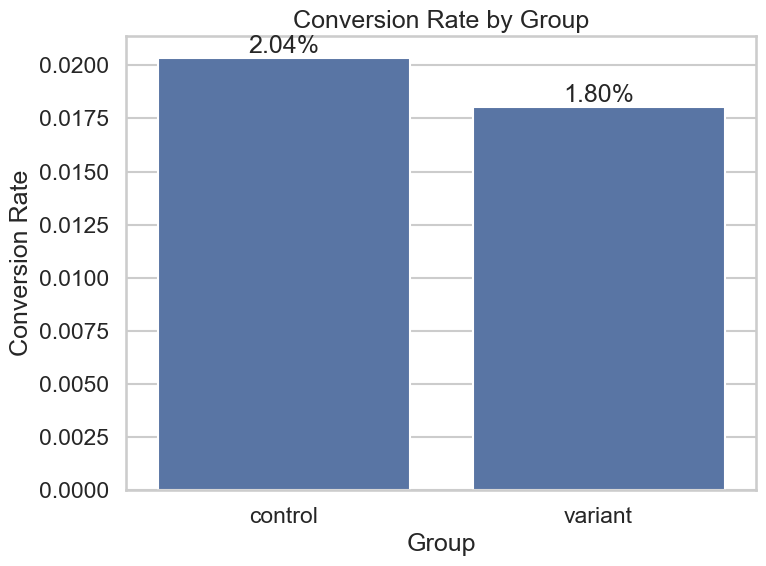

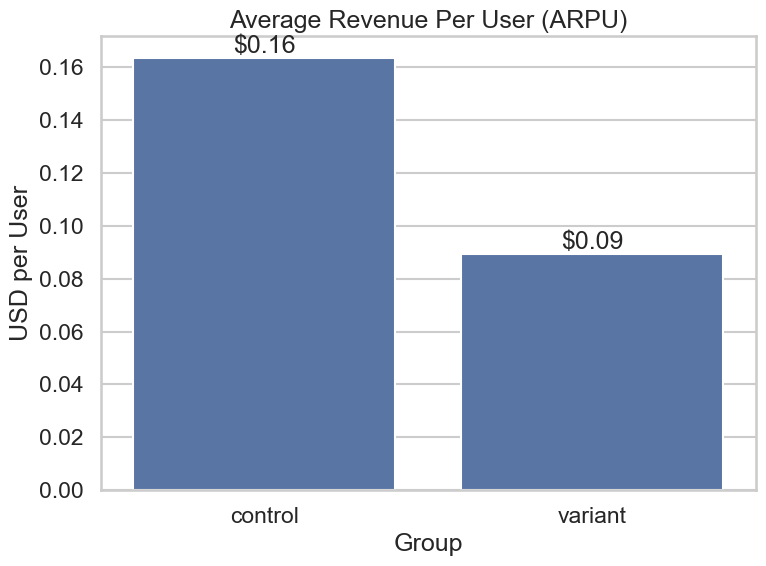

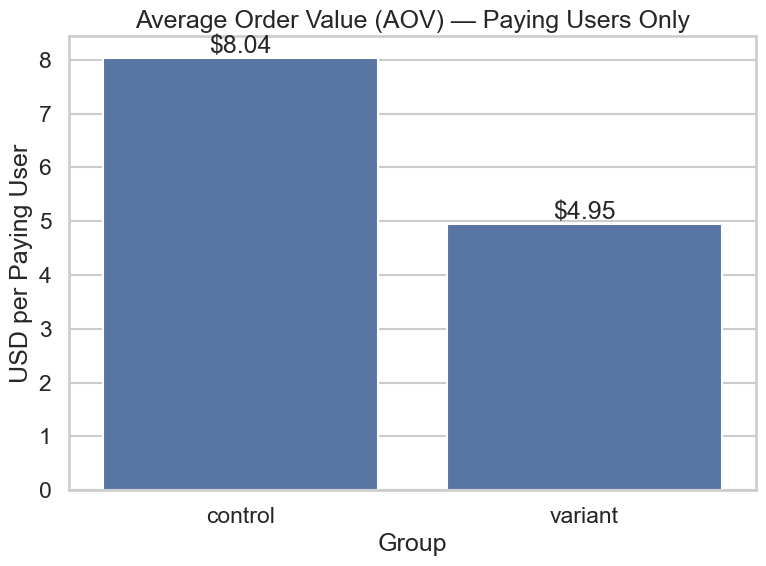

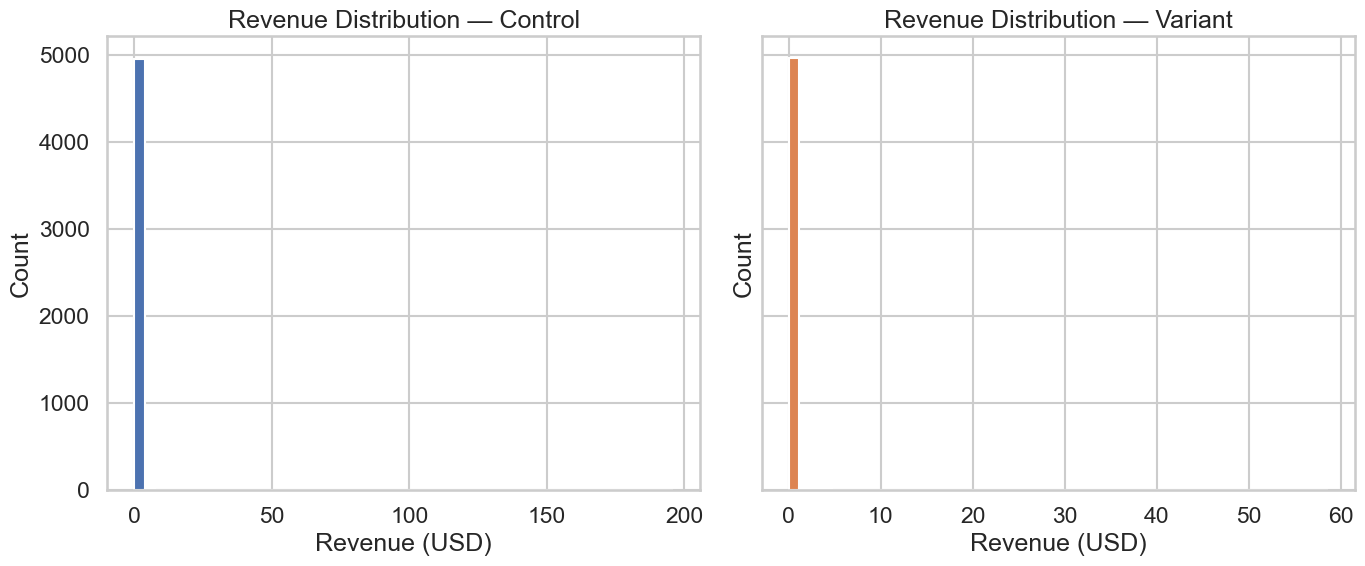

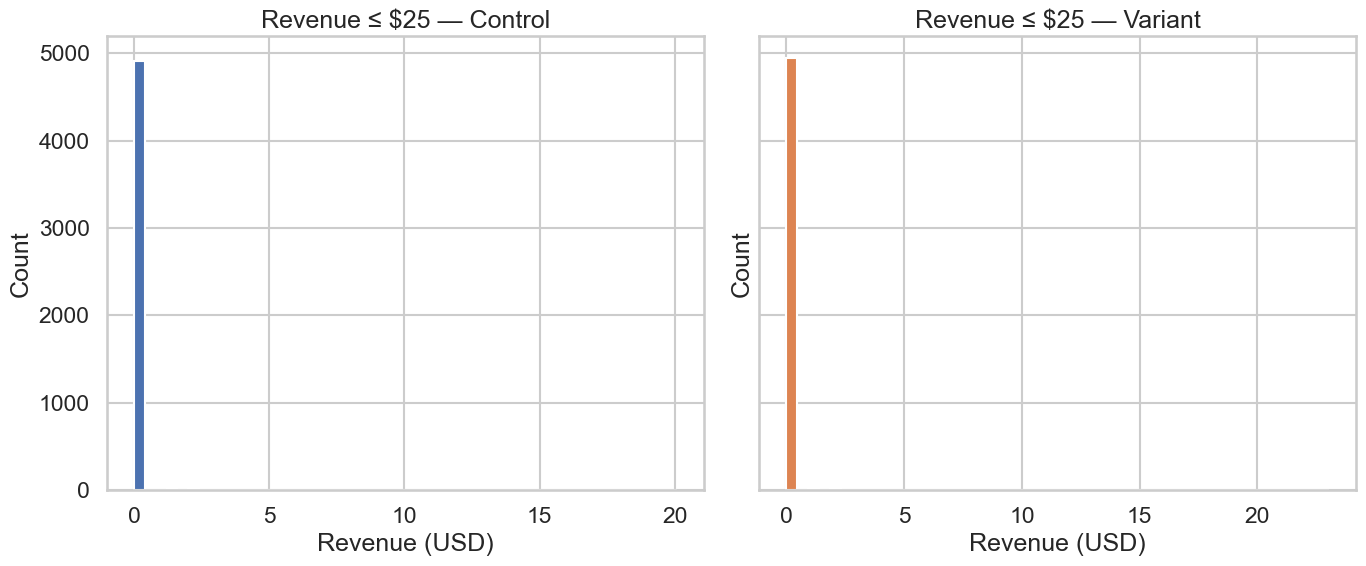

Required variant conversion ≈ 4.07%
Actual variant conversion   ≈ 1.80%


In [18]:
import pandas as pd

# 1) Load A/B Test Results dataset
df = pd.read_csv(r"C:\Users\tmanuel\Downloads\AB_Test_Results.csv")

# 2) Clean column names
df.columns = [c.strip().lower() for c in df.columns]

# 3) Create a Converted flag per row
df["converted"] = (df["revenue"] > 0).astype(int)

# 4) Compute unique users per variant
users_per_variant = (
    df.groupby("variant_name")["user_id"].nunique()
    .rename("unique_users")
)

# 5) Compute number of converters per variant
converters_per_variant = (
    df.groupby(["variant_name", "user_id"])["converted"].max()
    .groupby("variant_name").sum()
    .rename("converters")
)

# 6) Total revenue per variant
total_rev_per_variant = (
    df.groupby("variant_name")["revenue"].sum()
    .rename("total_revenue")
)

# 7 Combine into one summary table
summary = pd.concat(
    [users_per_variant, converters_per_variant, total_rev_per_variant], axis=1
)

# 8) Derived metrics
summary["conversion_rate"] = summary["converters"] / summary["unique_users"]
summary["arpu"] = summary["total_revenue"] / summary["unique_users"]
summary["aov"] = summary["total_revenue"] / summary["converters"]

# 9) Display
print(summary)



## Cleaned Setup from above

# Cell: imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Nice plotting style
sns.set(style="whitegrid", context="talk", palette="deep")

# Load your file (adjust path if needed)
df = pd.read_csv(r"C:\Users\tmanuel\Downloads\AB_Test_Results.csv")

# Clean column names for convenience
df.columns = [c.strip().lower() for c in df.columns]

# Create a per-row converted flag
df["converted"] = (df["revenue"] > 0).astype(int)

# Compute per-user metrics correctly (important with multi-row users)
unique_users = (
    df.groupby("variant_name")["user_id"].nunique()
    .rename("unique_users")
)

# Per-user conversion: a user is converted if ANY of their rows has revenue > 0
converters = (
    df.groupby(["variant_name","user_id"])["converted"].max()
      .groupby("variant_name").sum()
      .rename("converters")
)

# Total revenue per group
total_rev = df.groupby("variant_name")["revenue"].sum().rename("total_revenue")

# Combine into a tidy summary DataFrame
summary = pd.concat([unique_users, converters, total_rev], axis=1)

# Derived metrics
summary["conversion_rate"] = summary["converters"] / summary["unique_users"]
summary["arpu"] = summary["total_revenue"] / summary["unique_users"]
summary["aov"] = summary["total_revenue"] / summary["converters"]

# Round for display (don’t round when doing math)
display(summary.round({
    "conversion_rate": 4, "arpu": 4, "aov": 2, "total_revenue": 2
}))


## Helper to format labels (to keep charts clean)

# Cell: helper functions for nice bar labels
def add_value_labels(ax, fmt="{:.2f}", pct=False):
    """
    Add labels on top of bars. If pct=True, multiplies by 100 and adds '%'.
    """
    for p in ax.patches:
        val = p.get_height()
        if pct:
            ax.text(p.get_x()+p.get_width()/2., val,
                    f"{val*100:.2f}%", ha="center", va="bottom")
        else:
            ax.text(p.get_x()+p.get_width()/2., val,
                    fmt.format(val), ha="center", va="bottom")


## Converstion rate bar chart

# Cell: conversion rate bar chart
fig, ax = plt.subplots(figsize=(8,6))
plot_df = summary["conversion_rate"].sort_index()  # ensures control, variant order
sns.barplot(x=plot_df.index, y=plot_df.values, ax=ax)

ax.set_title("Conversion Rate by Group")
ax.set_xlabel("Group")
ax.set_ylabel("Conversion Rate")
add_value_labels(ax, pct=True)  # show percentages

plt.tight_layout()
plt.show()
# Optional: save
# fig.savefig("conversion_rate.png", dpi=150)


## Average Rate Per User (ARPU) Bar Chart


# Cell: ARPU bar chart
fig, ax = plt.subplots(figsize=(8,6))
plot_df = summary["arpu"].sort_index()
sns.barplot(x=plot_df.index, y=plot_df.values, ax=ax)

ax.set_title("Average Revenue Per User (ARPU)")
ax.set_xlabel("Group")
ax.set_ylabel("USD per User")
add_value_labels(ax, fmt="${:.2f}")

plt.tight_layout()
plt.show()
# fig.savefig("arpu.png", dpi=150)


## Average Order Value (AOV) Bar Chart (among payers)


# Cell: AOV bar chart
fig, ax = plt.subplots(figsize=(8,6))
plot_df = summary["aov"].sort_index()
sns.barplot(x=plot_df.index, y=plot_df.values, ax=ax)

ax.set_title("Average Order Value (AOV) — Paying Users Only")
ax.set_xlabel("Group")
ax.set_ylabel("USD per Paying User")
add_value_labels(ax, fmt="${:.2f}")

plt.tight_layout()
plt.show()
# fig.savefig("aov.png", dpi=150)


## Total Revenue bar chart


# Cell: total revenue bar chart
fig


## Revenue Distribution


# Cell: revenue distribution (histogram with zoom)
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for i, group in enumerate(["control", "variant"]):
    gdata = df.loc[df["variant_name"]==group, "revenue"]
    axes[i].hist(gdata, bins=50, color=sns.color_palette()[i])
    axes[i].set_title(f"Revenue Distribution — {group.capitalize()}")
    axes[i].set_xlabel("Revenue (USD)")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Optional: Zoom near zero to show activity below, say, $25
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
for i, group in enumerate(["control", "variant"]):
    gdata = df.loc[df["variant_name"]==group, "revenue"]
    axes[i].hist(gdata[gdata<=25], bins=50, color=sns.color_palette()[i])
    axes[i].set_title(f"Revenue ≤ $25 — {group.capitalize()}")
    axes[i].set_xlabel("Revenue (USD)")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()
# fig.savefig("revenue_distribution_zoom.png", dpi=150)


## Simple Statistical Annotation


required_variant_conv = (9.99/4.99) * summary.loc["control","conversion_rate"]
actual_variant_conv = summary.loc["variant","conversion_rate"]
print(f"Required variant conversion ≈ {required_variant_conv*100:.2f}%")
print(f"Actual variant conversion   ≈ {actual_variant_conv*100:.2f}%")



What we tested: Premium Plus price $9.99 (control) vs $4.99 (variant).

Key metrics: Conversion, Average Revenue Per User (ARPU), Average Order Value (AOV), total revenue.

Findings: Control wins on *ALL* metrics; variant's conversion lift is *far below* the break-even needed.

Recommendation: Keep the price of Premium Plus at $9.99. Consider testing other value levers (free trial lenght, features, bundles) instead of deep price cuts.

Caveats: Sample is very zero-heavy; ensure random assignment; in future, pre-register primary metric and do power analysis.